Prediksi umur abalone menggunakan kondisi pengukuran fisik. Umur abalone ditentukan dengan memotong cangkangnya, menodai, dan menghitung jumlah 'ring' melalui mikroskop.


*   Sex 			: Male, Female, and I (infant)
*   Length 		: Panjang cangkang dalam milimeter
*   Diameter 		: Diameter dalam milimeter
*   Height 			: Tinggi termasuk daging dalam cangkang dalam milimeter
*   Whole weight 		: Berat keseluruhan abalone dalam gram
*   Shucked weight	: Berat daging abalone gram
*   Viscera weight 	: Berat usus abalone setelah dikeringkan gram
*   Shell weight 		: Berat cangkang setelah dikeringkan gram
*   Rings 			: Jumlah rings yang jika ditambahkan 1.5 akan menunjukkan umur abalon 

In [2]:
from google.colab import files
import io

uploaded = files.upload()

Saving Abalone.csv to Abalone (1).csv


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

In [4]:
df = pd.read_csv(io.BytesIO(uploaded["Abalone.csv"]))
df

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


Karena kita ingin memprediksi umur (Age), maka variabel Age nantinya akan menjadi variabel dependen atau target. Akan tetapi variabel age belum ada, maka harus dibuat terlebih dahulu. Berdasarkan dari deskripsi pada dataset, kolom Age bisa didapat dari penjumlahan 1.5 dengan data setiap row di kolom Rings

In [5]:
df["Age"] = df["Rings"] + 1.5

In [6]:
# memisahkan features dan target
y = df.Age
X = df.drop(['Age'], axis=1)

In [7]:
# membagi dataset menjadi train set dan validation set (80 20)
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

Variabel "Sex" merupakan categorical variable, jadi harus dipreprocessing terlebih dahulu. Ada 3 metode untuk melakukannya, yaitu Drop categorical variablenya, ordinal encoding, atau one-hot encoding. Untuk kasus ini, metode Drop & one-hot encoding memungkinkan ketimbang ordinal encoding, karena jika ingin melakukan ordinal encoding, variabel "Sex" tidak memiliki tingkatan (rank).

In [8]:
# drop variabel "sex"
drop_X_train = X_train_full.select_dtypes(exclude=['object'])
drop_X_valid = X_valid_full.select_dtypes(exclude=['object'])

In [9]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(drop_X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [10]:
# Mencari nilai R - squared untuk mengukur explanatory power dari features
r2 = reg.score(drop_X_valid, y_valid)
print(f"R-squared : {r2}")

R-squared : 1.0


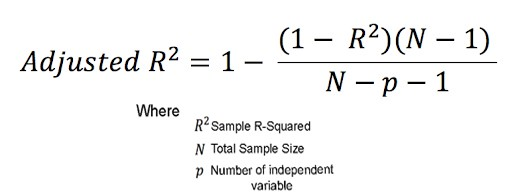

In [11]:
def adjusted_r2(r2, n, p):
  hasil = 1 - (((1-r2)*(n-1)) / (n-p-1))
  print(f"Adjusted R-squared : {hasil}")

In [12]:
drop_X_valid.shape

(836, 8)

In [13]:
# adjusted r2
n = drop_X_valid.shape[0]
p = drop_X_valid.shape[1]
adjusted_r2(r2, n, p)


Adjusted R-squared : 1.0


Nilai R-squared (r2) & Adjusted R-Squared (ar2) berjumlah 1. Ini artinya tidak ada error saat memprediksi menggunakan model diatas. Hal tersebut menandakan ada sesuatu yang salah, dugaan sementara saya ada pada datasetnya yang tidak bersih. 

In [14]:
# drop variabel "Rings"
dropRings_Xtrain = drop_X_train.drop("Rings", axis=1)
dropRings_Xvalid = drop_X_valid.drop("Rings", axis=1)

In [15]:
reg.fit(dropRings_Xtrain, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [16]:
# Mencari nilai R - squared untuk mengukur explanatory power dari features
r2 = reg.score(dropRings_Xvalid, y_valid)
print(f"R-squared : {r2}")

R-squared : 0.5300888107050662


In [17]:
dropRings_Xvalid.shape

(836, 7)

In [18]:
# adjusted r2
n = dropRings_Xvalid.shape[0]
p = dropRings_Xvalid.shape[1]
adjusted_r2(r2, n, p)

Adjusted R-squared : 0.5261161315685148


Setelah drop variabel "Rings", ternyata nilai r2 dan ar2 turun menjadi masing2  0.530 dan 0.526. Walaupun nilainya kecil dari nilai r2 yang ideal (0.70 - 0.90), tapi lebih baik ketimbang mendapat r2 = 1

In [19]:
# One-hot encoding
X_train_full = X_train_full.drop("Rings", axis=1)
X_valid_full = X_valid_full.drop("Rings", axis=1)

In [20]:
from sklearn.preprocessing import OneHotEncoder

X_train_full["Sex"] = X_train_full['Sex'].astype('category').cat.codes.astype("float")
X_valid_full["Sex"] = X_valid_full['Sex'].astype('category').cat.codes.astype("float")

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train_full[["Sex"]]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid_full[["Sex"]]))

OH_cols_train.index = X_train_full.index
OH_cols_valid.index = X_valid_full.index

num_X_train = X_train_full.drop("Sex", axis=1)
num_X_valid = X_valid_full.drop("Sex", axis=1)

OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

In [21]:
reg.fit(OH_X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [22]:
r2 = reg.score(OH_X_valid, y_valid)
print(f"R-squared : {r2}")

R-squared : 0.5383751781320009


In [23]:
OH_X_valid.shape

(836, 10)

In [24]:
# adjusted r2
n = OH_X_valid.shape[0]
p = OH_X_valid.shape[1]
adjusted_r2(r2, n, p)

Adjusted R-squared : 0.5327797257457221


Setelah menggunakan metode one-hot encoding, nilai r2 & ar2 naik. artinya untuk kasus ini metode one-hot encoding lebih baik daripada drop variabel

In [25]:
# 3 fungsi untuk menggunakan algoritma ML yang berbeda
# (OLS, Random Forest, dan XGBoost)
# Saya menggunakan metrik mean squared error

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

def ols_score(X_train, X_valid, y_train, y_valid):
  model = LinearRegression()
  model.fit(X_train, y_train)
  preds = model.predict(X_valid)
  mse = mean_squared_error(y_valid, preds)
  print(f"MSE (OLS) : {mse}") 

def rf_score(X_train, X_valid, y_train, y_valid):
  model = RandomForestRegressor(n_estimators=50, random_state=1)
  model.fit(X_train, y_train)
  preds = model.predict(X_valid)
  mse = mean_squared_error(y_valid, preds)
  print(f"MSE (Random Forest) : {mse}") 

def xgb_score(X_train, X_valid, y_train, y_valid):
  model = XGBRegressor(n_estimators=10000, learning_rate=0.035, random_state=0)
  model.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_valid, y_valid)])
  preds = model.predict(X_valid)
  mse = mean_squared_error(y_valid, preds)
  print(f"MSE (XGBoost) : {mse}") 

In [26]:
ols_score(OH_X_train, OH_X_valid, y_train, y_valid)

MSE (OLS) : 5.013389185855263


In [27]:
rf_score(OH_X_train, OH_X_valid, y_train, y_valid)

MSE (Random Forest) : 4.804708612440192


In [28]:
xgb_score(OH_X_train, OH_X_valid, y_train, y_valid)

[06:09:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:10.9518
Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:10.5923
[2]	validation_0-rmse:10.2459
[3]	validation_0-rmse:9.91139
[4]	validation_0-rmse:9.59009
[5]	validation_0-rmse:9.27791
[6]	validation_0-rmse:8.9809
[7]	validation_0-rmse:8.69389
[8]	validation_0-rmse:8.41874
[9]	validation_0-rmse:8.15313
[10]	validation_0-rmse:7.89635
[11]	validation_0-rmse:7.64945
[12]	validation_0-rmse:7.41046
[13]	validation_0-rmse:7.1818
[14]	validation_0-rmse:6.96086
[15]	validation_0-rmse:6.75044
[16]	validation_0-rmse:6.54421
[17]	validation_0-rmse:6.34997
[18]	validation_0-rmse:6.15947
[19]	validation_0-rmse:5.97791
[20]	validation_0-rmse:5.80193
[21]	validation_0-rmse:5.63664
[22]	validation_0-rmse:5.4758
[23]	validation_0-rmse:5.32277
[24]	validation_0-rmse:5.17423
[25]	validation_0-rmse:5.03461
[26]	validation_

In [29]:
import tensorflow as tf


model = tf.keras.models.Sequential([    
        # shape 10 karna kolom berjumlah 10 setelah OH encoding          
        tf.keras.layers.Input(shape=(10,)), 
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])
model.fit(OH_X_train, y_train, epochs=500)


Epoch 1/500
105/105 [==============================] - 1s 3ms/step - loss: 47.6197 - mse: 47.6197
Epoch 2/500
105/105 [==============================] - 0s 3ms/step - loss: 7.2005 - mse: 7.2005
Epoch 3/500
105/105 [==============================] - 0s 3ms/step - loss: 6.6358 - mse: 6.6358
Epoch 4/500
105/105 [==============================] - 0s 3ms/step - loss: 6.3347 - mse: 6.3347
Epoch 5/500
105/105 [==============================] - 0s 3ms/step - loss: 6.0657 - mse: 6.0657
Epoch 6/500
105/105 [==============================] - 0s 3ms/step - loss: 5.8495 - mse: 5.8495
Epoch 7/500
105/105 [==============================] - 0s 3ms/step - loss: 5.7150 - mse: 5.7150
Epoch 8/500
105/105 [==============================] - 0s 3ms/step - loss: 5.4736 - mse: 5.4736
Epoch 9/500
105/105 [==============================] - 0s 3ms/step - loss: 5.2495 - mse: 5.2495
Epoch 10/500
105/105 [==============================] - 0s 3ms/step - loss: 5.0649 - mse: 5.0649
Epoch 11/500
105/105 [===============

In [30]:
model.evaluate(OH_X_valid, y_valid, verbose=0)

[4.419747352600098, 4.419747352600098]

Model terprediksi dengan sempurna berdasarkan hasil dari cell diatas

**Kesimpulan**

*   MSE (OLS) : 5.013389185855263
*   MSE (Random Forest) : 4.804708612440192
*   MSE (XGBoost) : 4.786220126012435
*   MSE (DNN) : 4.0204